# Lesson 2 - Redux 1
By me

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Keras linear model
A dense layer is a linear model (followed by an activation function that isn't linear).

In [10]:
x = random((30, 2))
y = np.dot(x, [2., 3.]) + 1.

In [14]:
x[:5]

array([[ 0.1236,  0.3438],
       [ 0.0099,  0.0348],
       [ 0.3863,  0.8384],
       [ 0.5574,  0.8295],
       [ 0.1156,  0.1746]])

In [15]:
y[:5]

array([ 2.2787,  1.1243,  4.2878,  4.6032,  1.755 ])

In [19]:
# create a linear model using keras.models' Sequential class (for the model) and Dense class (for the fully connected layer)
lm = Sequential([ Dense(1, input_shape=(2,))])

In [20]:
# compile the model giving it an optimizer + lr (from keras.optimizers) and a loss function - mean squared error
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

In [21]:
# once we compile the model gets the initial random weights within its layers
# so we can evaluate it on the x and y
lm.evaluate(x, y, verbose=1)

30/30 [==============================] - 0s


16.146297454833984

In [22]:
# we can also fit it
lm.fit(x, y, nb_epoch=5, batch_size=1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 1.8599     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.2408     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0824     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0279     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0110     


In [23]:
lm.evaluate(x, y, verbose=1)

30/30 [==============================] - 0s


0.0050635826773941517

In [24]:
# we can also take a look at the weights directly - to see if they match the params we put in the np.dot (2,3 and + 1)
lm.get_weights()

[array([[ 1.9199],
        [ 2.7909]], dtype=float32), array([ 1.1284], dtype=float32)]

## Train a linear model to classify 1000 outputs of vgg16
So just plop an extra dense layer at the end to turn 1000 categories into 2 (cats and dogs).

In [25]:
!pwd

/home/ubuntu/courses/deeplearning1/nbs


In [26]:
path = "data/dogscats/sample/"
model_path = path + 'models/'

In [27]:
batch_size = 4

from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Our approach:

1. Get true labels for every image
2. Use the vgg 1000 class predictions for each image as input
3. Feed that to our linear model

In [28]:
val_batches = get_batches(path + "valid/", shuffle=False, batch_size=1)
batches = get_batches(path + "train/", shuffle=False, batch_size=1)

Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [29]:
# use bcolz for speed and saving space
import bcolz
def bcolz_save(filename, array): c=bcolz.carray(array, rootdir=filename, mode="w"); c.flush()
def bcolz_load(filename): return bcolz.open(filename)[:]

In [31]:
# join batches into 1 array
val_data = get_data(path + "/valid")
trn_data = get_data(path + "/train")

Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [32]:
trn_data.shape

(16, 3, 224, 224)

In [33]:
# save the data
bcolz_save(model_path + "/val_data.bc", val_data)
bcolz_save(model_path + "/trn_data.bc", trn_data)

In [35]:
# load them up easily
val_data = bcolz_load(model_path + "/val_data.bc")
trn_data = bcolz_load(model_path + "/trn_data.bc")

In [36]:
val_data.shape

(8, 3, 224, 224)

In [37]:
# Not sure how that's useful in this example

In [38]:
# but let's see that keras didn't one-hot encode the classes (it returns them in a single array, for all 8 val examples)
val_batches.classes

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [51]:
# we'll want to one-hot encode them cause that's better input to the linear model
# we'll use sklearn's OneHotEncoder
def one_hot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [52]:
# let's break that definition into smaller pieces
step_1 = val_batches.classes.reshape(-1,1)
step_1
# ok, so reshape(-1,1) is essentially a transpose

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [53]:
step_2 = OneHotEncoder().fit_transform(step_1)
print(step_2)

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 1)	1.0
  (5, 1)	1.0
  (6, 1)	1.0
  (7, 1)	1.0


In [54]:
step_3 = step_2.todense()
step_3

matrix([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]])

In [55]:
step_4 = np.array(step_3)
step_4

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [57]:
# seemed to break down, let's see if the function works
val_labels = one_hot(val_batches.classes)
trn_labels = one_hot(batches.classes)
val_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [58]:
# WHY IS THIS JUST 2 CLASSES??? Oh, cause the data folders only had 2 classes. 
# Now we can get the 1000 probabilities from vgg for these images
# and also use the bcolz saved data

In [60]:
trn_features = model.predict(trn_data, batch_size=4)

In [61]:
val_features = model.predict(val_data, batch_size=4)

In [62]:
trn_features.shape

(16, 1000)

In [63]:
val_features.shape

(8, 1000)

In [65]:
# we can save them up again
bcolz_save(model_path + "/trn_lastlayer_features.bc", trn_features)
bcolz_save(model_path + "/val_lastlayer_features.bc", val_features)

In [66]:
# and load them
trn_features = bcolz_load(model_path + "/trn_lastlayer_features.bc")
val_features = bcolz_load(model_path + "/val_lastlayer_features.bc")

In [72]:
# now we can define our Linear Model - with 2 outputs and 1000 inputs
lm = Sequential([Dense(2, activation="softmax", input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1), loss="categorical_crossentropy", metrics=["accuracy"])

In [73]:
# train the model
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=4, validation_data=(val_features, val_labels))

Train on 16 samples, validate on 8 samples
Epoch 1/3
16/16 [==============================] - 0s - loss: 0.6321 - acc: 0.5625 - val_loss: 0.4270 - val_acc: 0.8750
Epoch 2/3
16/16 [==============================] - 0s - loss: 0.3153 - acc: 1.0000 - val_loss: 0.3439 - val_acc: 0.8750
Epoch 3/3
16/16 [==============================] - 0s - loss: 0.2204 - acc: 1.0000 - val_loss: 0.3124 - val_acc: 0.8750


In [74]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_11 (Dense)                 (None, 2)             2002        dense_input_7[0][0]              
Total params: 2002
____________________________________________________________________________________________________


### Investigating the model
Look at confidence, low and high etc.

In [75]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

4/8 [==============>...............] - ETA: 0s

array([ 0.9207,  0.9163,  0.5594,  0.9075,  0.2786,  0.0858,  0.5789,  0.3093], dtype=float32)

In [76]:
preds[:8]

array([0, 0, 0, 0, 1, 1, 0, 1])

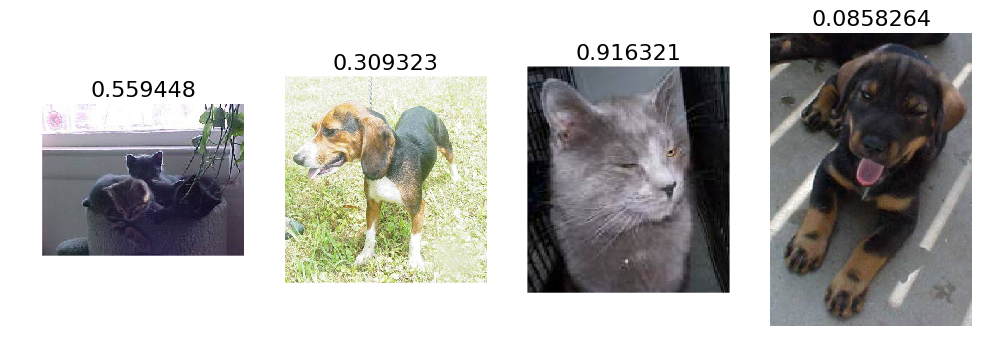

In [77]:
filenames = val_batches.filenames
# Number of images to view for each visualization task
n_view = 4
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

## Modifying the model
We can, instead of plopping a linear model on top of vgg output, just manipulate its internals.
It was weird to plop a linear model on top of the last layer which was also linear (dense) + softmax. It makes more sense to remove that one and replace it with one that gives out 2 outputs.

In [78]:
# let's look at the model first
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
# let's make sure that our model (the one we've been using) is also structured that way
model.summary()

In [81]:
# and yes, it is, because we didn't actually add our linear model into the vgg model that we were using
# let's remove the last layer and make all the previous ones not trainable (we trust their weights)
model.pop()
for layer in model.layers: layer.trainable = False

In [83]:
# now add our new final layer
model.add(Dense(2, activation="softmax"))

In [84]:
# this command shows the docstring: ??vgg.finetune()

In [85]:
# let's compile our model!
model.compile(optimizer=RMSprop(lr=0.1), loss="categorical_crossentropy", metrics=["accuracy"])

In [93]:
# and fit it on batches (use keras.image.ImageDataGenerator())
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [100]:
# define fit function
def fit_model(a_model, batches, val_batches, nb_epochs=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epochs,
                       validation_data=val_batches, nb_val_samples=val_batches.N)

In [101]:
batches.N

16

In [102]:
# train the model
fit_model(model, batches, val_batches, nb_epochs=2)

Epoch 1/2
16/16 [==============================] - 0s - loss: 0.1355 - acc: 0.8750 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 2/2
16/16 [==============================] - 0s - loss: 1.0118 - acc: 0.9375 - val_loss: 1.0798 - val_acc: 0.8750


In [105]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

8/8 [==============================] - 0s     


array([ 1.    ,  1.    ,  0.999 ,  1.    ,  0.    ,  0.    ,  0.9998,  0.    ], dtype=float32)

In [106]:
# we can also finetune all dense layers and even set the learning rate globally via
# K.set_value(opt.lr, 0.01)

NameError: name 'val_classes' is not defined